## Linear Regression Approach
***

### 1. Importing Libraries

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [25]:
%matplotlib inline

### 2. Load OSIC Tabular Data

In [26]:
patient_data = pd.read_csv('../data/osic-pulmonary-fibrosis-progression/train.csv')

In [27]:
patient_data.shape

(1549, 7)

In [28]:
patient_data.columns

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus'], dtype='object')

In [29]:
patient_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


### 3. Preprocessing

In [30]:
# Dropping duplicate records in th train data
patient_data.drop_duplicates(subset=['Patient', 'Weeks'], keep=False, inplace=True)
patient_data.shape

(1535, 7)

#### 3.1 Encoding categorical columns [ 'Sex', 'SmokingStatus']
- Sex { Male:1 | Female:0 }
- SmokingStatus { Ex-smoker:1 | Never smoked:2 | Currently smokes:0 }

In [31]:
le = LabelEncoder()

# Encoding 'Sex' column in Patient data
patient_data['Sex'] = le.fit_transform(patient_data['Sex'])

# Encoding 'SmokingStatus' column Patient data
patient_data['SmokingStatus'] = le.fit_transform(patient_data['SmokingStatus'])

In [32]:
patient_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,1,1
1,ID00007637202177411956430,5,2214,55.712129,79,1,1
2,ID00007637202177411956430,7,2061,51.862104,79,1,1
3,ID00007637202177411956430,9,2144,53.950679,79,1,1
4,ID00007637202177411956430,11,2069,52.063412,79,1,1


In [33]:
patient_data['Sex'].value_counts()

1    1212
0     323
Name: Sex, dtype: int64

In [34]:
patient_data['SmokingStatus'].value_counts()

1    1030
2     423
0      82
Name: SmokingStatus, dtype: int64

#### 3.2 Transforming Patient data w.r.to 1st week's measurement
- Each of the patient's measurements will be appended by 1st week's measurements
- New schema of the dataframe- ['PatientID', 'first_week', 'first_FVC',	'Age',	'Sex',	'SmokingStatus',	'target_week',	'target_FVC']

In [35]:
# create training data
data_point = []

# itrating through the train data and appening each measurement w.r.to 1st week's measurement
for p in patient_data['Patient'].unique():
    patientData = patient_data[patient_data['Patient'] == p]
    firstMeasure = list(patientData.iloc[0, :].values)
        
    for i, week in enumerate(patientData['Weeks'].iloc[1:]):
        fvc = patientData.iloc[i, 2]
        DataPoint = firstMeasure + [week, fvc]
        data_point.append(DataPoint)
    
# creating final dataframe for training        
patient_data_v2 = pd.DataFrame(data_point)
patient_data_v2.columns = ['PatientID', 'first_week', 'first_FVC', 'first_Percent', 'Age', 'Sex', 'SmokingStatus'] + ['target_week', 'target_FVC']

patient_data_v2.head()

,PatientID,first_week,first_FVC,first_Percent,Age,Sex,SmokingStatus,target_week,target_FVC
0,ID00007637202177411956430,-4,2315,58.253649,79,1,1,5,2315
1,ID00007637202177411956430,-4,2315,58.253649,79,1,1,7,2214
2,ID00007637202177411956430,-4,2315,58.253649,79,1,1,9,2061
3,ID00007637202177411956430,-4,2315,58.253649,79,1,1,11,2144
4,ID00007637202177411956430,-4,2315,58.253649,79,1,1,17,2069


#### 3.3 Rescaling Numerical Variables
Columns rescaled = [ 'first_week', 'first_FVC',	'first_Percent',	'Age', 'target_week', 'target_FVC' ]

In [36]:
# importing sklearn minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [37]:
# Apply scaler() to all numerical varibales
num_vars =  [ 'first_week', 'first_FVC', 'first_Percent', 'Age', 'target_week', 'target_FVC' ]
patient_data_v2[num_vars] = scaler.fit_transform(patient_data_v2[num_vars])

In [38]:
patient_data_v2.head()

,PatientID,first_week,first_FVC,first_Percent,Age,Sex,SmokingStatus,target_week,target_FVC
0,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.030303,0.267050
1,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.045455,0.248923
2,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.060606,0.221464
3,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.075758,0.236360
4,ID00007637202177411956430,0.011905,0.241456,0.135886,0.769231,1,1,0.121212,0.222900


#### 3.4 Train/ Test split
- Splitting the dataset into train and test set (80:20)

In [39]:
# importing sklearn
from sklearn.model_selection import train_test_split

In [40]:
# spliting train and test sets in 70-30 proportion
np.random.seed(0)
patient_train, patient_test = train_test_split(patient_data_v2, train_size = 0.8, test_size = 0.2, random_state = 100)

In [41]:
# Checking the shape of train and test set
print('Train Set: ',  patient_train.shape)
print('Test Set: ',  patient_test.shape)

Train Set:  (1087, 9)
Test Set:  (272, 9)


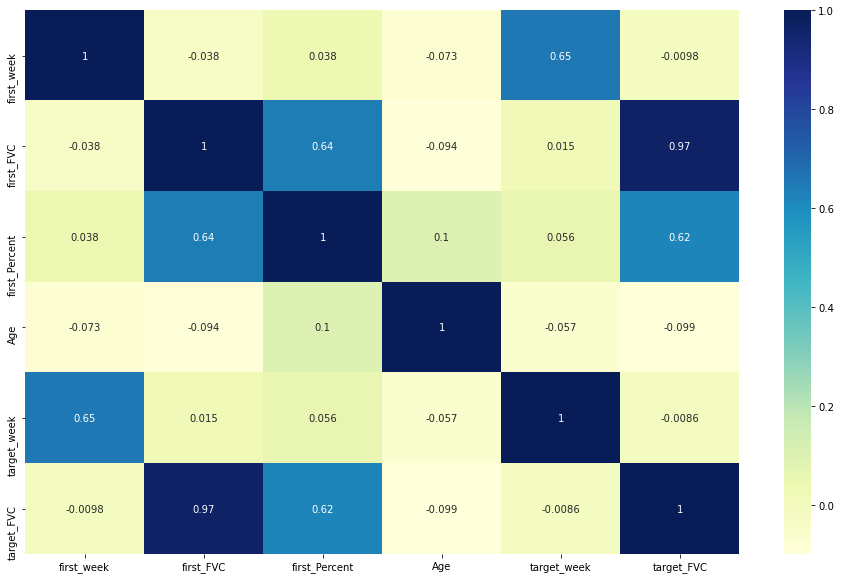

In [42]:
# Correlation between various numerical variables

plt.figure(figsize = (16, 10))
sns.heatmap(patient_train[num_vars].corr(), annot = True, cmap="YlGnBu")

plt.draw()

- Strong correlation between **first_fvc** and **target_fvc** is quite evident in the heatmap

### 4. Linear Regression Model
- A linear regression model will be build using all the features present in train data set
- Target Variable- **'target_FVC'**

#### 4.1 Building model using train data

In [43]:
# Spliting train data into predictors and predictee
x_train= patient_train.drop(columns = ['PatientID', 'target_FVC'])
y_train= patient_train['target_FVC']

In [44]:
y_train

1271    0.165650
708     0.245513
661     0.359835
1007    0.148241
434     0.243539
          ...   
802     0.232053
53      0.335607
350     0.046303
79      0.372577
792     0.214465
Name: target_FVC, Length: 1087, dtype: float64

In [45]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)
prediction = model.predict(x_train)

In [46]:
model.coef_

array([ 0.06088959,  0.91565491,  0.01514653, -0.00891506,  0.00783111,
       -0.00229281, -0.06104395])

#### 4.2 Making prediction in the test set

In [47]:
# Spliting train data into predictors and predictee
x_test= patient_test.drop(columns = ['PatientID', 'target_FVC'])
y_test= patient_test['target_FVC']

In [48]:
test_prediction = model.predict(x_test)

### 5. Error Analysis
- Analyzing Model performance in train and test set

In [49]:
# Ignoring warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### 5.1 Train Accuracy/ Error Analysis

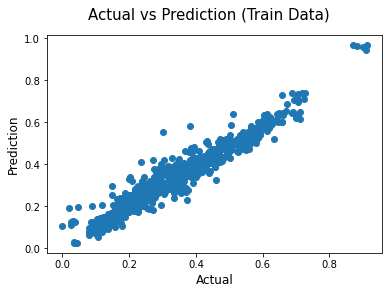

In [51]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_train,prediction)
fig.suptitle('Actual vs Prediction (Train Data)', fontsize=15)   # Plot heading 
plt.xlabel('Actual', fontsize=12)                   # X-label
plt.ylabel('Prediction', fontsize=12) 
plt.savefig('../plots/Regression/ActualvsPrediction-TrainData.png' ,bbox_inches="tight")

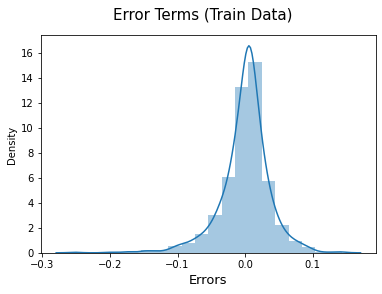

In [52]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - prediction), bins = 20)
fig.suptitle('Error Terms (Train Data)', fontsize = 15)      # Plot heading 
plt.xlabel('Errors', fontsize = 13) 
plt.savefig('../plots/Regression/ErrorTerms-TrainData.png' ,bbox_inches="tight")

#### Error terms

In [53]:
#RMSE/MAE computation using sklearn library
from sklearn.metrics import *

In [54]:
print('Train set r2 score = ', r2_score(y_train, prediction))
print('Train set MAE = ', mean_absolute_error(y_train, prediction))
print('Train set MSE = ', mean_squared_error(y_train, prediction))
print('Train set RMSE = ', np.sqrt(mean_squared_error(y_train, prediction)))

Train set r2 score =  0.9388864433785576
Train set MAE =  0.025115163504218784
Train set MSE =  0.0013487105189948334
Train set RMSE =  0.036724794335636975


#### 5.1 Test Error Analysis

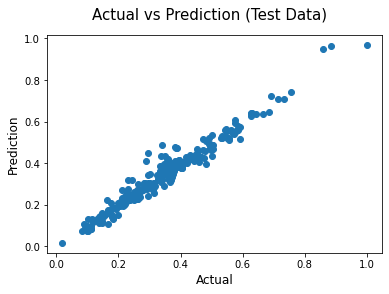

In [55]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,test_prediction)
fig.suptitle('Actual vs Prediction (Test Data)', fontsize=15)   # Plot heading 
plt.xlabel('Actual', fontsize=12)                   # X-label
plt.ylabel('Prediction', fontsize=12) 
plt.savefig('../plots/Regression/ActualvsPrediction-TestData.png' ,bbox_inches="tight")

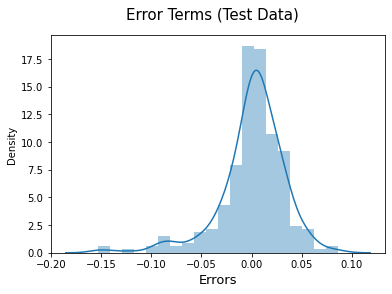

In [56]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_test - test_prediction), bins = 20)
fig.suptitle('Error Terms (Test Data)', fontsize = 15)                  # Plot heading 
plt.xlabel('Errors', fontsize = 13) 
plt.savefig('../plots/Regression/ErrorTerms-TestData.png' ,bbox_inches="tight")

#### Error terms

In [57]:
print('Test set r2 score = ', r2_score(y_test, test_prediction))
print('Test set MAE = ', mean_absolute_error(y_test, test_prediction))
print('Test set MSE = ', mean_squared_error(y_test, test_prediction))
print('Test set RMSE = ', np.sqrt(mean_squared_error(y_test, test_prediction)))

Test set r2 score =  0.9547046041259842
Test set MAE =  0.022477335591630742
Test set MSE =  0.0010593102076587174
Test set RMSE =  0.03254704606655906


### Model Prediction equation

In [58]:
(model.coef_).round(4)

array([ 0.0609,  0.9157,  0.0151, -0.0089,  0.0078, -0.0023, -0.061 ])


#### The equation of our best fitted line is:

$ FVC = 0.0609  \times  first\_week + 0.9157  \times  first\_FVC + 0.0151 \times first\_Percent - 0.0089 \times Age + 0.0078 \times Sex - 0.0023 \times SmokingStatus - 0.061 \times target\_week $